Este notebook contém uma breve explicação do processo de web scraping realizado para obter os informes mensais estruturados de fundos de investimento imobiliário

In [1]:
# bibliotecas Python
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import time
import re
import requests
import base64
import os

In [2]:
from IPython import display

Como uma maneira de economizar recursos de memória, a visibilidade do navegador pode ser desativada durante a execução do script. Logo abaixo mostra como pode ser realizado essa configuração para o webdriver do Firefox.

In [3]:
# define a visibilidade do navegador durante a execução do script. 
# options = Options()
# options.add_argument('-headless')

A variável "cnpj" recebe o cnpj do Fundo de Investimento Imobiliário (Fii) de interesse. O caminho do diretório informado na variável "dados" estará(ão) o(s) sub-diretório(s) que irá(ão) receber os arquivos baixados. O nome de cada sub-diretório corresponderá ao cnpj informado. Exemplo: "../dados/11728688000147/". Os arquivos baixados são do tipo XML.

In [4]:
cnpj = '11728688000147'
dados = f'{os.getcwd()}/dados/'
os.mkdir(f'{dados}{cnpj}')

A variável "URL" recebe o endereço web do sistema FundosNet que dá acesso aos documentos. Para acessar os documentos de um FII específico é necessário informar o seu CNPJ como complemento do endereço web. Exemplo "../abrirGerenciadorDocumentosCVM?cnpjFundo=11728688000147".

In [5]:
navegador = webdriver.Firefox()
URL = 'https://fnet.bmfbovespa.com.br/fnet/publico/abrirGerenciadorDocumentosCVM?cnpjFundo='
navegador.get(f'{URL}{cnpj}')

Na página web acessada há a possibilidade de filtrar os documentos desejados conforme características específicas. Para efetuar o comando de clique no botão 'Exibir Filtros' é necessário informar o nome que o identifica, no caso, id, que será 'showFiltros'.


In [6]:
botao_exibir_filtros = navegador.find_element(By.ID, 'showFiltros')
botao_exibir_filtros.click()
time.sleep(2)

Uma janela suspensa aparecerá com várias opções de filtragem. As que nos interessa são Categoria, Tipo e Situação. Essas opções de filtragem são composta de elementos dos tipos dropdown, campo de texto e botão. Um clique será executado em cada dropdown para que seja mostrado o campo de texto e suas opções. Em vez de clicar sobre a opção deseja, optou-se por informar o seu nome no campo de texto. Um clique é efetuado no botão Filtrar para executar a filtragem dos documentos.

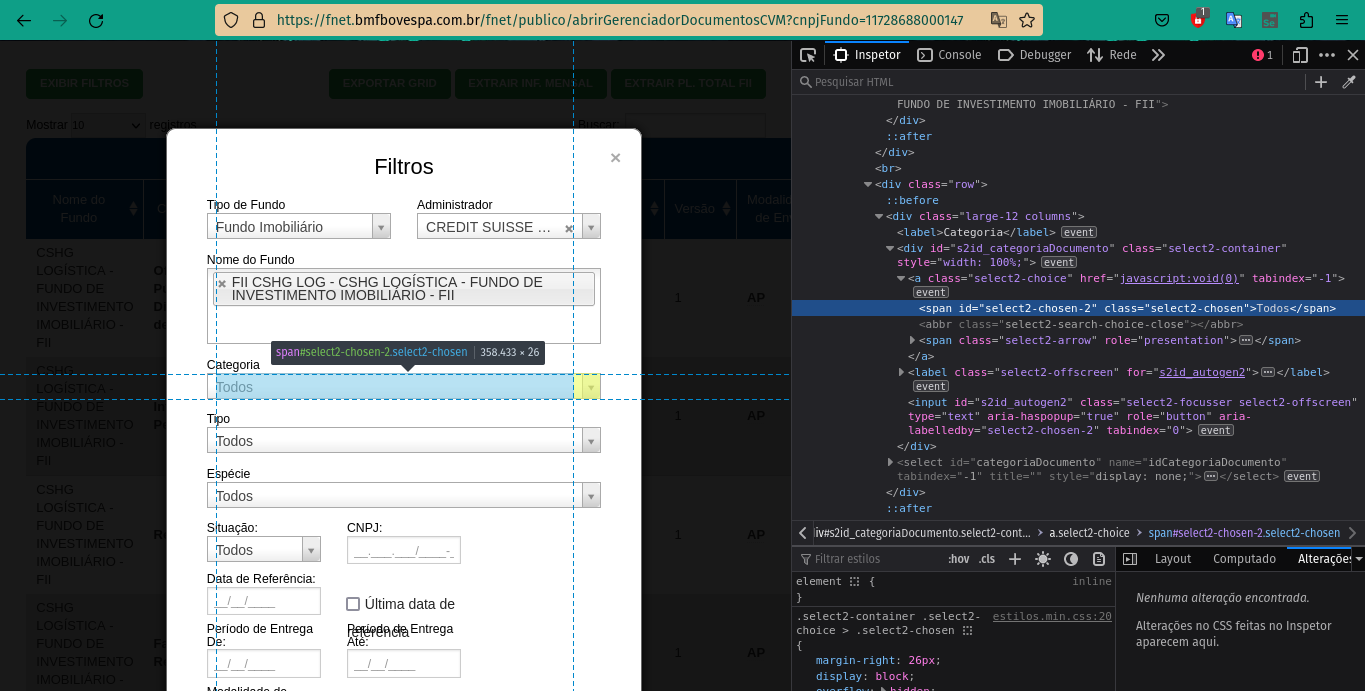

In [7]:
# exibe a captura de tela com a referência do elemento HTML dropdown de categoria
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/dropdown-categoria.png', width=1000, height=600)

In [8]:
dropdown_categoria = navegador.find_element(By.ID, 'select2-chosen-2')
dropdown_categoria.click()
time.sleep(2)

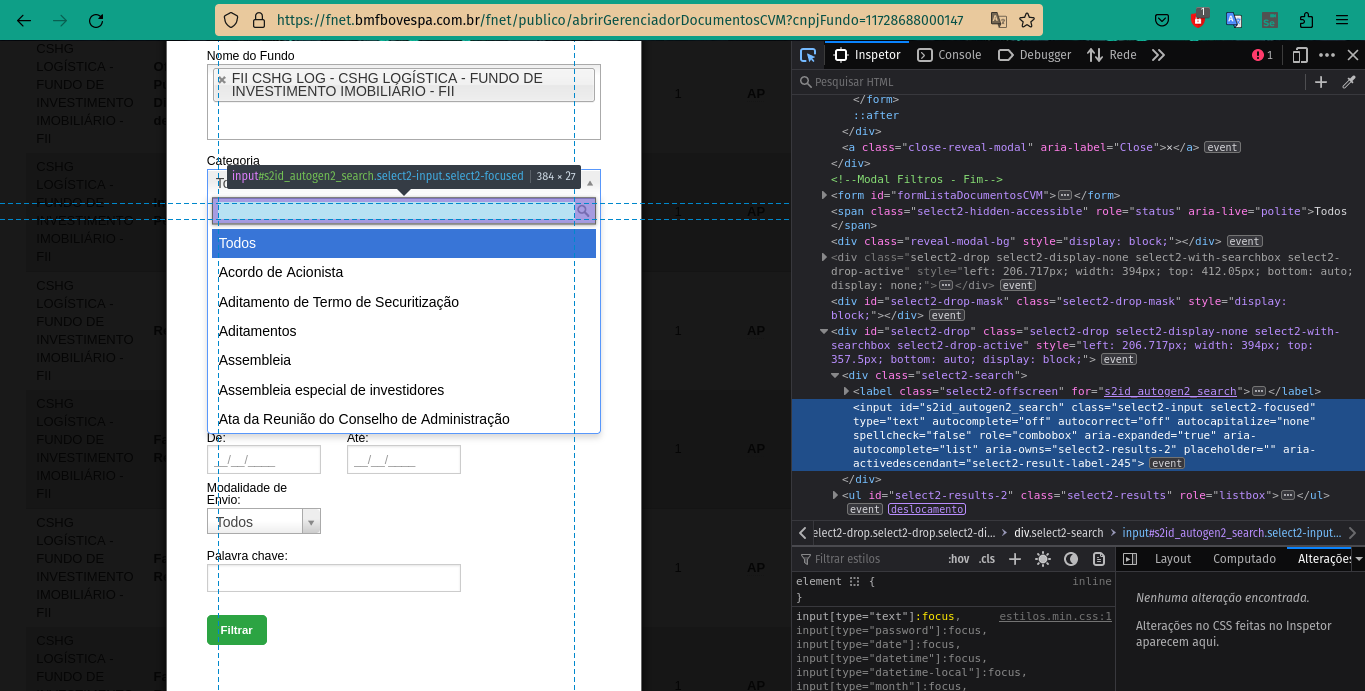

In [9]:
# exibe a captura de tela com a referência do elemento HTML campo de texto de categoria
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/campo-texto-categoria.png', width=1000, height=600)

In [10]:
campo_categoria = navegador.find_element(By.ID, 's2id_autogen2_search')
campo_categoria.send_keys('Informes Periódicos', Keys.ENTER)
time.sleep(2)

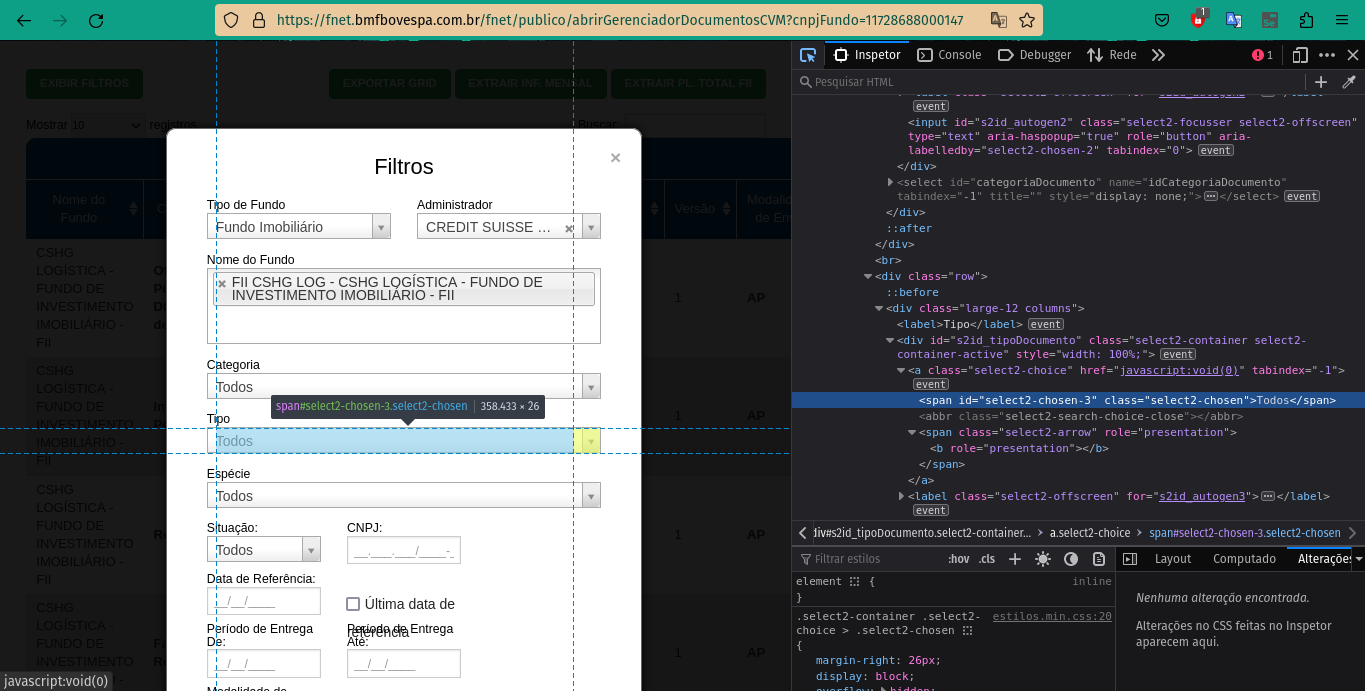

In [11]:
# exibe a captura de tela com a referência do elemento HTML dropdown de categoria
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/dropdown-tipo.png', width=1000, height=600)

In [12]:
dropdown_tipo = navegador.find_element(By.ID, 'select2-chosen-3')
dropdown_tipo.click()
time.sleep(2)

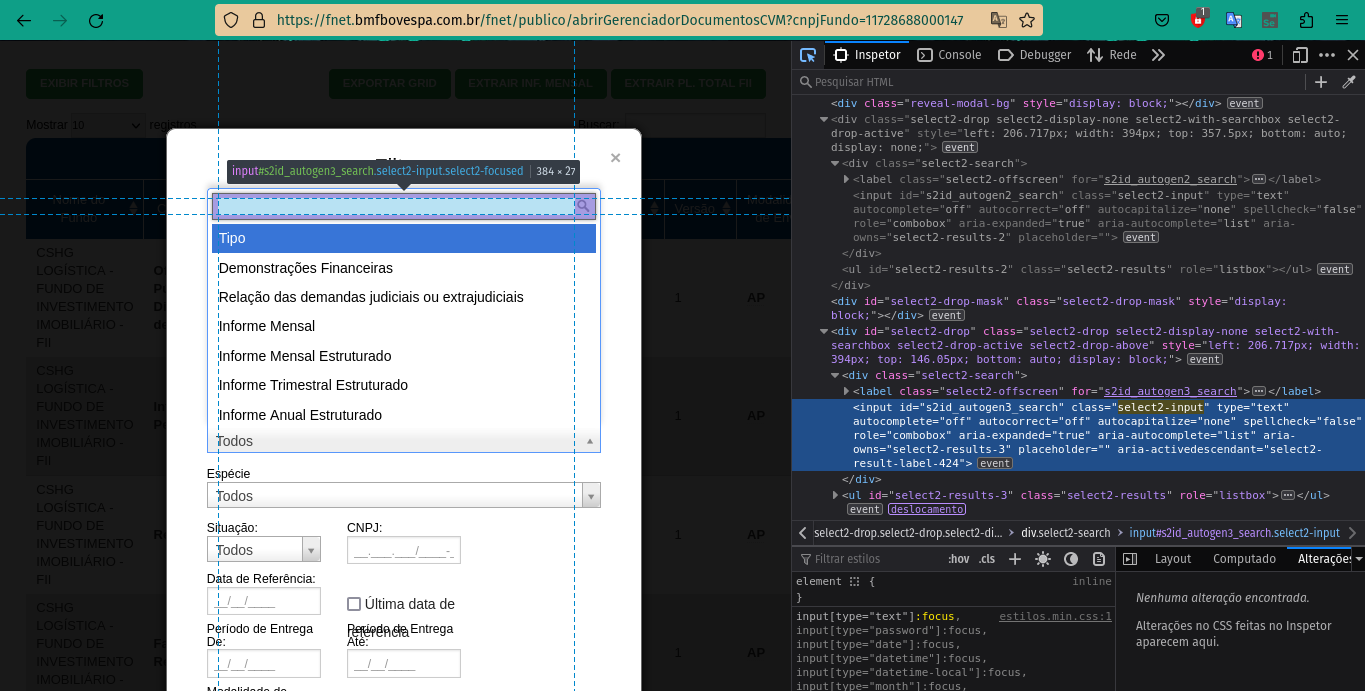

In [13]:
# exibe a captura de tela com a referência do elemento HTML campo de texto de categoria
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/campo-texto-tipo.png', width=1000, height=600)

In [14]:
campo_tipo = navegador.find_element(By.ID, 's2id_autogen3_search')
campo_tipo.send_keys('Informe Mensal Estruturado', Keys.ENTER)
time.sleep(2)

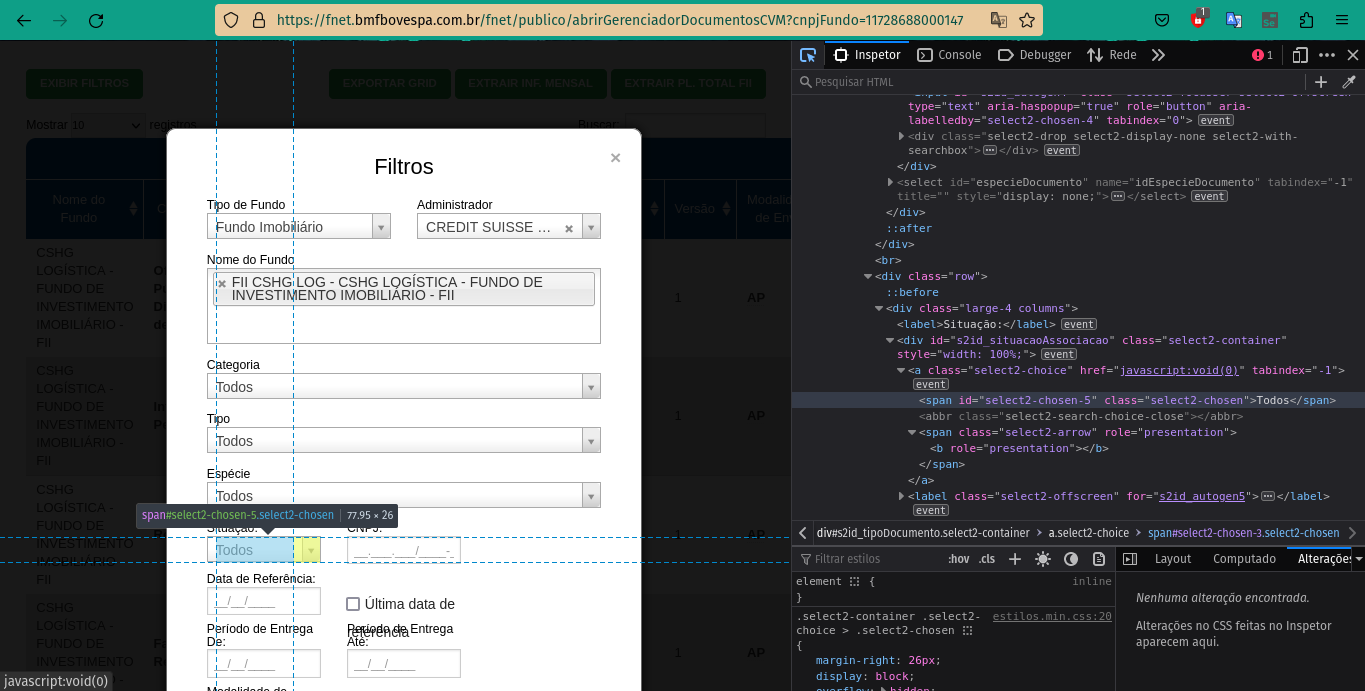

In [15]:
# exibe a captura de tela com a referência do elemento HTML dropdown de Situação
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/dropdown-situacao.png', width=1000, height=600)

In [16]:
dropdown_situacao = navegador.find_element(By.ID, 'select2-chosen-5')
dropdown_situacao.click()
time.sleep(2)

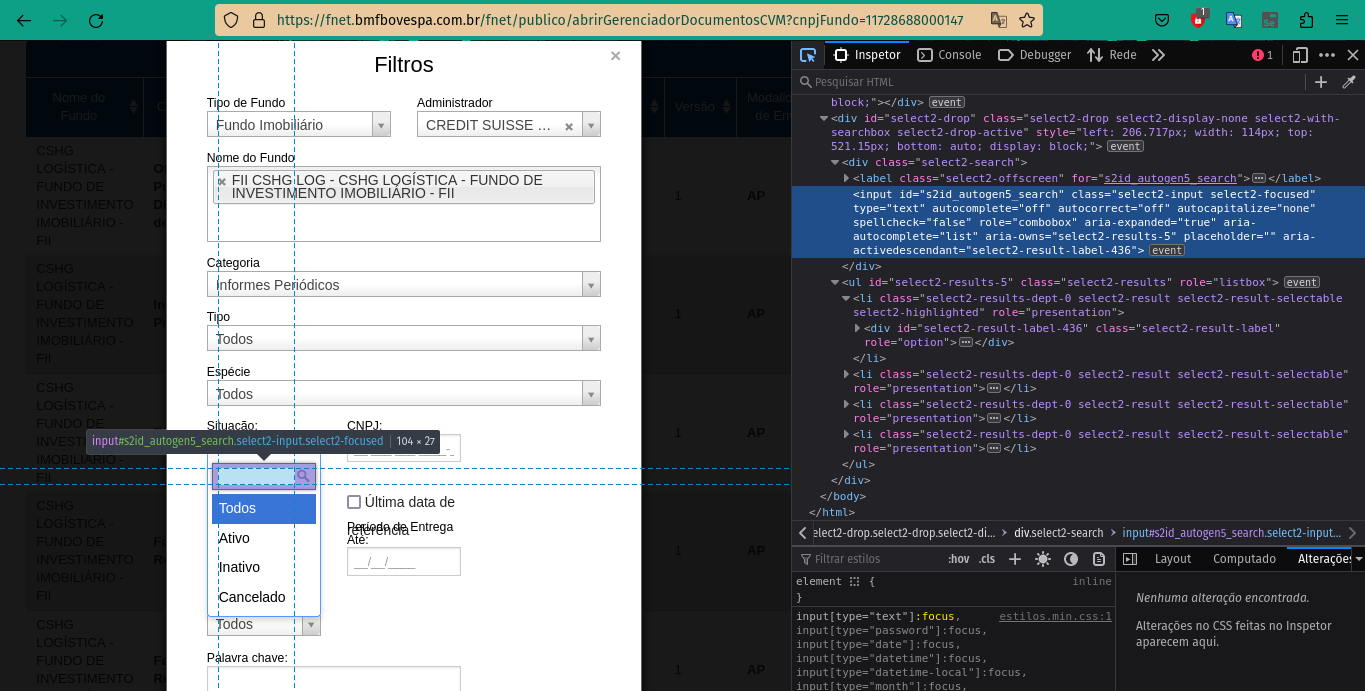

In [17]:
# exibe a captura de tela com a referência do elemento HTML campo de texto de Situação
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/campo-texto-situacao.png', width=1000, height=600)

In [18]:
campo_situacao = navegador.find_element(By.ID, 's2id_autogen5_search')
campo_situacao.send_keys('Ativo', Keys.ENTER)
time.sleep(2)

Selecionado todos os filtros desejados, efetua-se o clique no botão 'Filtrar".

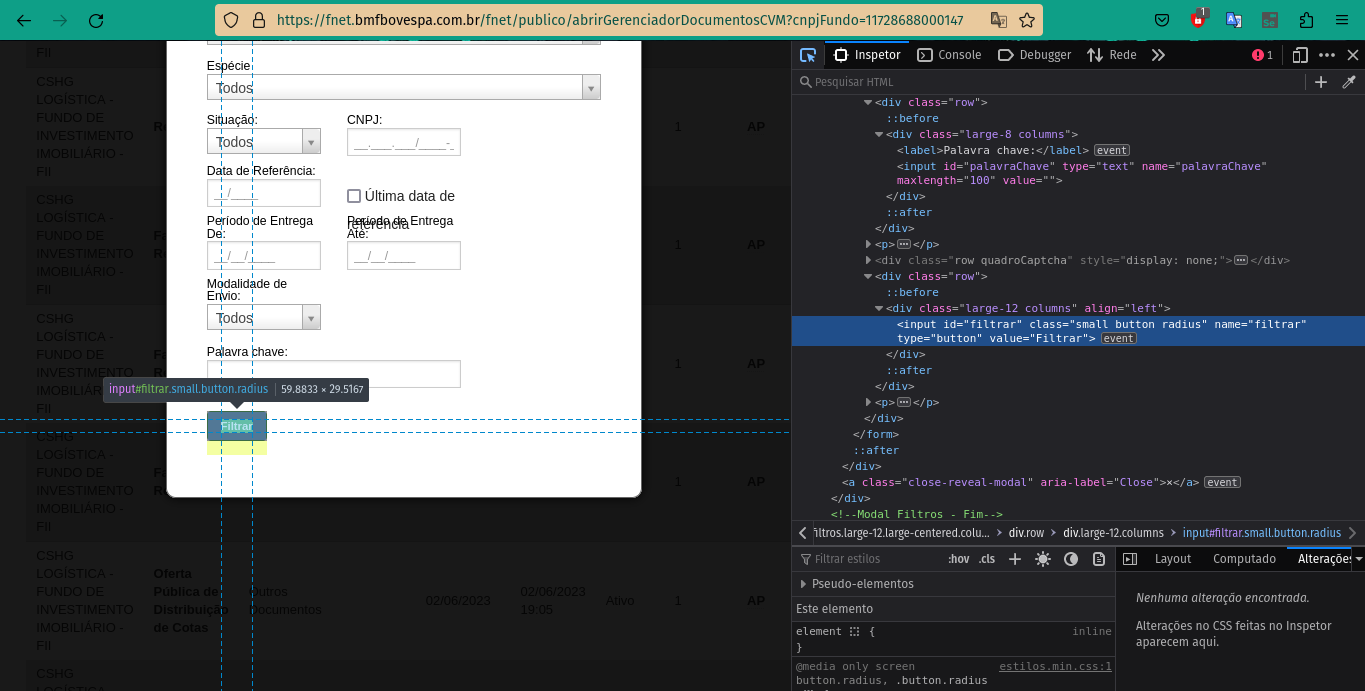

In [19]:
# exibe a captura de tela com a referência do elemento HTML botão Filtrar
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/botao-filtrar.png', width=1000, height=600)

In [20]:
botao_filtrar = navegador.find_element(By.ID, 'filtrar')
botao_filtrar.click()
time.sleep(2)

Após a aplicação de todos os filtros, é possível ainda modificar a quantidade de registros que podem ser visualizados em uma única página. A função abaixo procura pelo o elemento correspondente à modificação da visibilidade de registros e redefine para a quantidade de registros desejados.

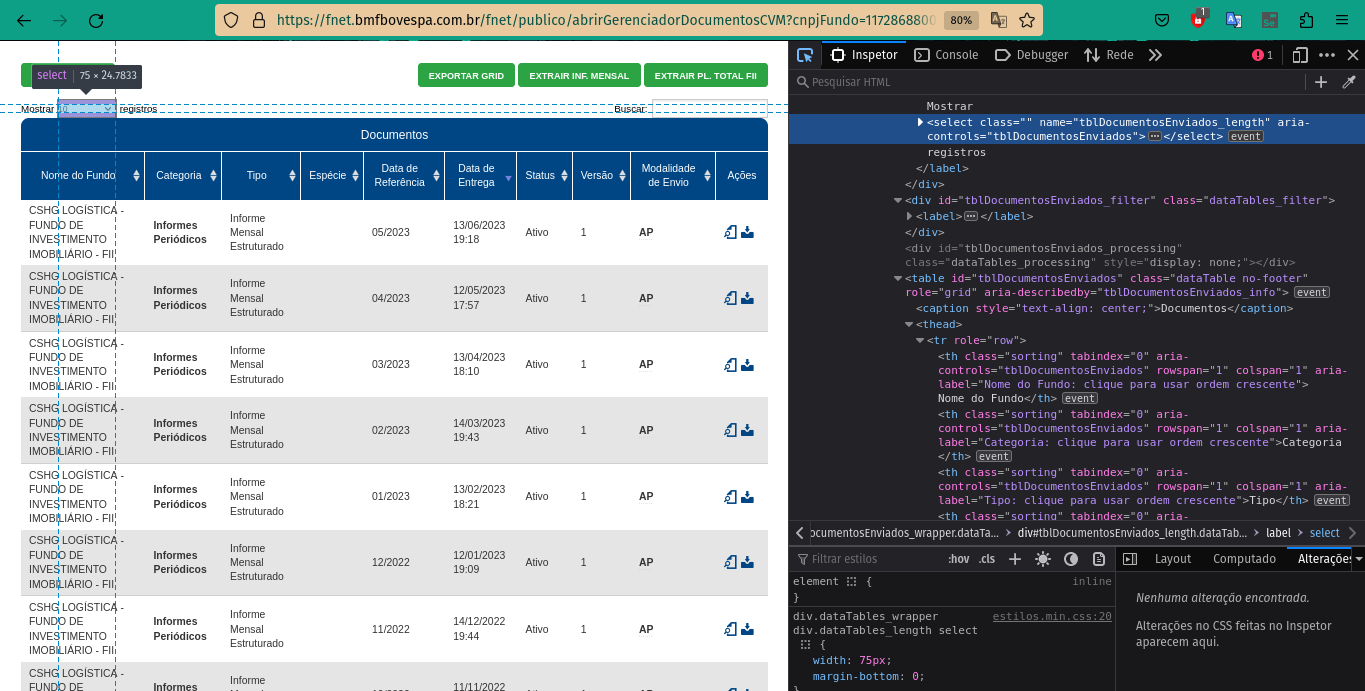

In [21]:
# exibe a captura de tela com a referência do elemento HTML drowpdown de seleção do número de registros para visualização
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/dropdown-num-registros.png', width=1000, height=600)

In [22]:
mostrar_num_registros = Select(navegador.find_element(By.NAME, 'tblDocumentosEnviados_length'))
mostrar_num_registros.select_by_visible_text('100')
time.sleep(2)

A página web no seu estado atual disponibiliza a visualização e o download dos documentos. Todos os links da página são armazenados na variável "links_encontrados". Contudo, são tipo webelement, assim, não sendo compreensíveis. Iterando em cada webelement da lista de links encontrados é possível obter um "link compreensível" através do atributo ".get_attribute".

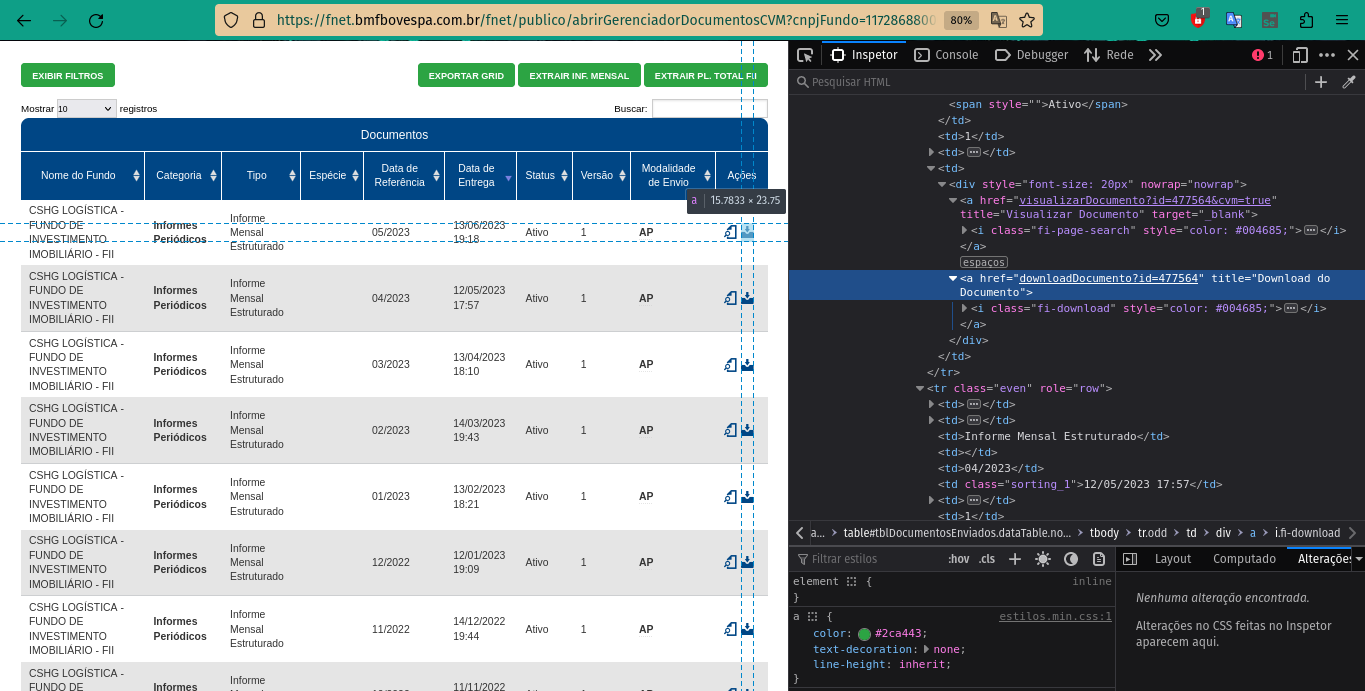

In [23]:
# exibe a captura de tela com a referência do elemento HTML <a> o qual define um hiperlink
display.Image(filename='/home/diego/Projetos/WebscrapingFundosNet/img/hiperlink.png', width=1000, height=600)

In [24]:
links_encontrados = navegador.find_elements(By.TAG_NAME, 'a') # tipo webelement
links_compreensiveis = [link.get_attribute('href') for link in links_encontrados]
links_compreensiveis[0 : 10]


['javascript:void(0)',
 'javascript:void(0)',
 'https://fnet.bmfbovespa.com.br/fnet/publico/abrirGerenciadorDocumentosCVM?cnpjFundo=11728688000147#',
 'javascript:void(0)',
 'javascript:void(0)',
 'javascript:void(0)',
 'javascript:void(0)',
 'javascript:void(0)',
 None,
 'https://fnet.bmfbovespa.com.br/fnet/publico/visualizarDocumento?id=477564&cvm=true']

A lista "links_compreensiveis" contém elementos que não possuem um tipo definido (None). A lista "links_definidos" recebe os elementos diferentes do tipo None, após a sua remoção. Como está lista contêm elementos que não estão relacionados aos documentos de interesse (download), eles serão também removidos e armazenados em uma nova lista - "link_downloads".

In [25]:
links_definidos = [link for link in links_compreensiveis if link is not None]
links_definidos[0 : 10]

['javascript:void(0)',
 'javascript:void(0)',
 'https://fnet.bmfbovespa.com.br/fnet/publico/abrirGerenciadorDocumentosCVM?cnpjFundo=11728688000147#',
 'javascript:void(0)',
 'javascript:void(0)',
 'javascript:void(0)',
 'javascript:void(0)',
 'javascript:void(0)',
 'https://fnet.bmfbovespa.com.br/fnet/publico/visualizarDocumento?id=477564&cvm=true',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=477564']

In [26]:
links_downloads = [link for link in links_definidos if 'downloadDocumento' in link]
links_downloads[0 : 10]

['https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=477564',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=462079',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=444950',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=429701',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=415226',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=400810',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=389518',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=376402',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=364799',
 'https://fnet.bmfbovespa.com.br/fnet/publico/downloadDocumento?id=351570']

Com os links armazenados em uma lista, não é mais necessário manter o navegador aberto. Para economizar espação de memória ele pode ser finalizados.

In [27]:
navegador.quit()

Por fim, o script abaixo executa os downloads dos informes mensais no formato XML a partir da lista "links_downloads". Os arquivos são armazenados na máquina local.

In [28]:
for link in links_downloads:
    doc = requests.get(link, allow_redirects=True, verify=True)
    nome = re.findall('filename="(.+)"', doc.headers.get('content-disposition'))[0]
    # REDUZIR NOME DO ARQUIVO .XML ELIMINANDO CNPJ INICIAL
    diretorio = f'{dados}{cnpj}/{nome}'

    with open(diretorio, 'wb') as arquivo:
        arquivo.write(base64.b64decode(doc.content))
        time.sleep(0.5)